# Lab 5. Graph Neural Networks - Graph Level Regression

### Build a graph neural network to predict the soluability of different molecules (solute) in water (solvent).

Complete the items marked TODO below. Your tasks will 
involve adding an experimenting with different graph pooling methods to aggregate node level embeddings to create a representation for the entire graph (molecule). The graph level representation is sent through a linear output layer as a regression value. Soluability values for each molecule is used as ground truth.

TODO: Global Pooling (stack different aggregations).   
Step 0 - _read_ through the notebook carefully.  
Step 1 - global_mean_pool   
Step 2 - global_max_pool   
Step 3 - global_mean_pool + global_max_pool  
Step 4 - Extra-credit: try one or more advanced pooling stratetgies or experiment with variations on the GNN i.e., number of layer hops, etc. 

Create a results table. For each experiment, record the pooling method, number of epochs, and RMSE

Pooling documentation: https://pytorch-geometric.readthedocs.io/en/1.3.0/modules/nn.html#module-torch_geometric.nn.glob

Jay Urbain, PhD

Credits:    
https://pytorch-geometric.readthedocs.io/en/latest/    
https://www.rdkit.org/    
https://arxiv.org/abs/1703.00564  
https://deepfindr.github.io/    



## Installing Pytorch Geometric and RDKit

- Pytorch Geometric => Build Graph Neural Network
- RDKit => Handle Molecule Data

Note: I verified this on Google Colab 1/9/2023.


In [ ]:
# !nvidia-smi

# Add this in a Google Colab cell to install the correct version of Pytorch Geometric.
import torch

def format_pytorch_version(version):
  return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
  return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric 

> Make sure you clicked "RESTART RUNTIME" above and pick up here after the restart.

In [ ]:
#@title
# Install rdkit
import sys
import os
import requests
import subprocess
import shutil
from logging import getLogger, StreamHandler, INFO
 
 
logger = getLogger(__name__)
logger.addHandler(StreamHandler())
logger.setLevel(INFO)


In [ ]:
!pip install rdkit

## Background info on the Dataset

In the following we will use a dataset provided in the dataset collection of PyTorch Geometric ([datasets](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html)). 


>"ESOL is a small dataset consisting of water solubility data for 1128 compounds. The dataset
has been used to train models that estimate solubility directly from chemical structures (as
encoded in SMILES strings). Note that these structures don’t include 3D coordinates, since
solubility is a property of a molecule and not of its particular conformers."

Solubility describes the amount of a substance that can be dissolved in another substance. This measurement can range from nearly completely insoluble under any conditions, such as oil and water, to near infinitely soluble, such as ethanol and water.

When water is the solvent, solubility can be expressed in relative volume, commonly as grams of solute per 100 grams of solvent.

**>>> Machine Learning task: How are different molecules dissolving in water?**


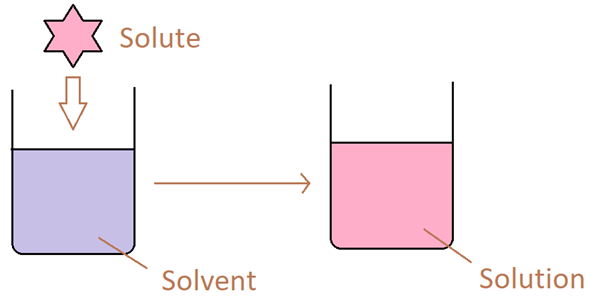

Source: https://www.differencebetween.com/difference-between-solubility-and-solubility-product/

### SMILES representation and important sidenodes

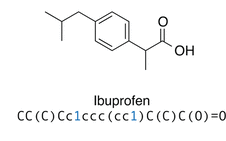
 
 Source: https://medium.com/@sunitachoudhary103/generating-molecules-using-a-char-rnn-in-pytorch-16885fd9394b

- Using the plain SMILES string as input is not suitable
- This will not consider the molecule structure but rather the grammar of the SMILES string
- The SMILES string can be different for a molecule, depending on the notation ( a unique molecule can have multiple SMILES strings )
- Chemical graphs however, are invariant to permutations --> Graph Neural Networks


## Looking into the Dataset

In [ ]:
import rdkit
from torch_geometric.datasets import MoleculeNet
 
# Load the ESOL dataset
data = MoleculeNet(root=".", name="ESOL")
data

In [ ]:
# Investigating the dataset
print("Dataset type: ", type(data))
print("Dataset features: ", data.num_features)
print("Dataset target: ", data.num_classes)
print("Dataset length: ", data.len)
print("Dataset sample: ", data[0])
print("Sample  nodes: ", data[0].num_nodes)
print("Sample  edges: ", data[0].num_edges)

# edge_index = graph connections
# smiles = molecule with its atoms
# x = node features (32 nodes have each 9 features)
# y = labels (dimension)

In [ ]:
# Investigating the features
# Shape: [num_nodes, num_node_features]
data[0].x

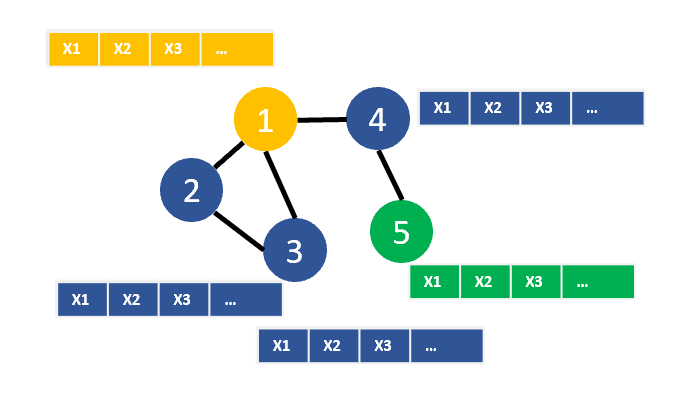

In [ ]:
# Investigating the edges in sparse COO format
# Shape [2, num_edges]
data[0].edge_index.t()

In [ ]:
data[0].y

In the following we will perform predictions based on the graph level. This means we have one y-value for the whole graph, as shown on the left image below. The right image would be node-level-predictions.

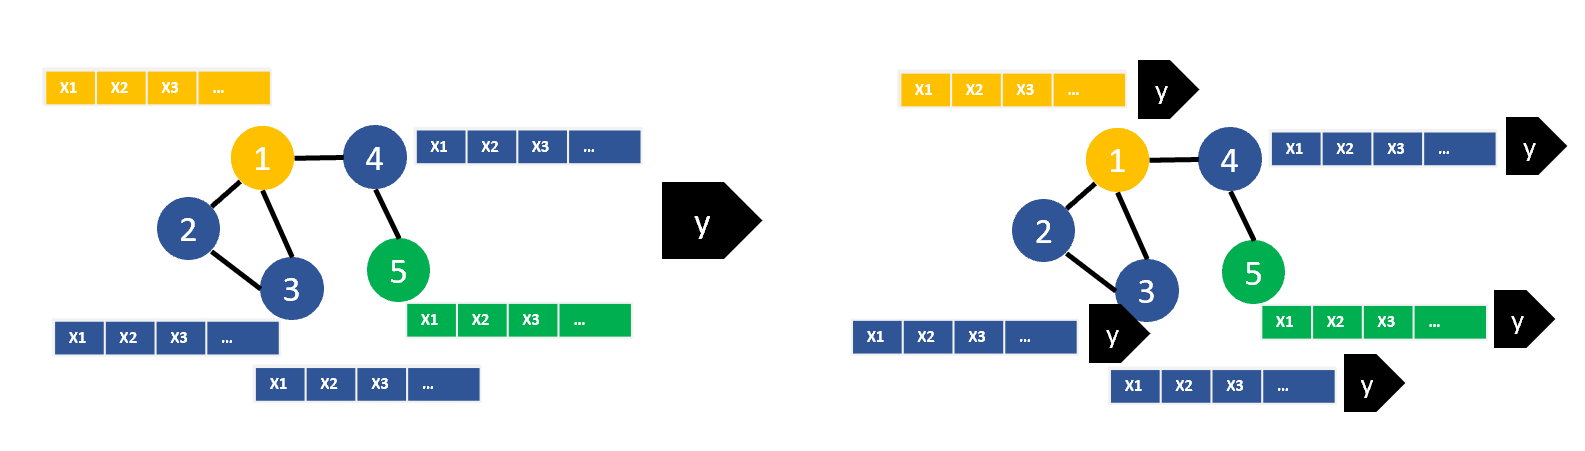

## Converting SMILES to RDKit molecules - Visualizing molecules

Next we want to have our SMILES molecules as graphs...

In [ ]:
data[0]["smiles"]

In [ ]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
molecule = Chem.MolFromSmiles(data[0]["smiles"])
molecule

In [ ]:
type(molecule)

- We can also obtain the features from this RDKit representation
- It provides molecular features e.g. atom features (type, ...), edges, etc. 
- In our case we have the information explicitly given already in the dataset.
- Otherwise we would calculate the node features from those atom properties

For datasets containing SMILES representations this would be the way to go

## Implementing the Graph Neural Network 

Building a Graph Neural Network works the same way as building a Convolutional Neural Network, we simply add GCN layers.

The GCN extends torch.nn.Module.
GCNConv expects:
- in_channels = Size of each input sample.
- out_channels = Size of each output sample.

Apply three convolutional layers, which means we learn the information about 3 neighbor hops. After that we apply a pooling layer to combine the information of the individual nodes, as we want to perform graph-level prediction.

Always keep in mind that different learning problems (node, edge or graph prediction) require different GNN architectures.

For example for node-level prediction you will often encounter masks. For graph-level predictions on the other hand you need to combine the node embeddings.

In [ ]:
import torch
from torch.nn import Linear
import torch.nn.functional as F 
from torch_geometric.nn import GCNConv, TopKPooling, global_mean_pool
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
embedding_size = 64

class GCN(torch.nn.Module):
    def __init__(self):
        # Init parent
        super(GCN, self).__init__()
        torch.manual_seed(42)

        # GCN layers
        self.initial_conv = GCNConv(data.num_features, embedding_size)
        self.conv1 = GCNConv(embedding_size, embedding_size)
        self.conv2 = GCNConv(embedding_size, embedding_size)
        self.conv3 = GCNConv(embedding_size, embedding_size)

        # Output layer
        # TODO: adjust the dimensionality for the number of 
        # concatenations in your pooling.
        dim=2
        self.out = Linear(embedding_size*2, 1)

    def forward(self, x, edge_index, batch_index):
        # First Conv layer
        hidden = self.initial_conv(x, edge_index)
        hidden = F.tanh(hidden)

        # Other Conv layers
        hidden = self.conv1(hidden, edge_index)
        hidden = F.tanh(hidden)
        hidden = self.conv2(hidden, edge_index)
        hidden = F.tanh(hidden)
        hidden = self.conv3(hidden, edge_index)
        hidden = F.tanh(hidden)
          
        # TODO: Global Pooling (stack different aggregations)
        # Step 1 - global_mean_pool 
        # Step 2 - global_max_pool
        # Step 3 - global_mean_pool + global_max_pool
        # Step 4 - Extra-credit: try one or more advanced pooling stratetgies 
        # or experiment with variations on the GNN i.e., number of layer hops, etc. 

        hidden = None # add pooling layer here

        # Apply a final (linear) classifier.
        out = self.out(hidden)

        return out, hidden

model = GCN()
print(model)
print("Number of parameters: ", sum(p.numel() for p in model.parameters()))

- We could also reduce the embeddings, but as we have large molecules we use 64
- The more layers we add, the more information we get about the graph
- For the regression problem we use a Linear layer as final output layer
- We try to use not too many parameters, as we only have ~1k samples

## Training the GNN

In [ ]:
from torch_geometric.data import DataLoader
import warnings
warnings.filterwarnings("ignore")

# Root mean squared error
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0007)  

# Use GPU for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Wrap data in a data loader
data_size = len(data)
NUM_GRAPHS_PER_BATCH = 64
loader = DataLoader(data[:int(data_size * 0.8)], 
                    batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)
test_loader = DataLoader(data[int(data_size * 0.8):], 
                         batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)

def train(data):
    # Enumerate over the data
    for batch in loader:
      # Use GPU
      batch.to(device)  
      # Reset gradients
      optimizer.zero_grad() 
      # Passing the node features and the connection info
      pred, embedding = model(batch.x.float(), batch.edge_index, batch.batch) 
      # Calculating the loss and gradients
      loss = loss_fn(pred, batch.y)     
      loss.backward()  
      # Update using the gradients
      optimizer.step()   
    return loss, embedding

print("Starting training...")
losses = []
for epoch in range(2000):
    loss, h = train(data)
    losses.append(loss)
    if epoch % 100 == 0:
      print(f"Epoch {epoch} | Train Loss {loss}")

### Visualizing the Training loss

In [ ]:
# Visualize learning (training loss)
import seaborn as sns
losses_float = [float(loss.cpu().detach().numpy()) for loss in losses] 
loss_indices = [i for i,l in enumerate(losses_float)] 
plt = sns.lineplot(loss_indices, losses_float)
plt

### Getting a test prediction

In [ ]:
import pandas as pd 

# Analyze the results for one batch
test_batch = next(iter(test_loader))
with torch.no_grad():
    test_batch.to(device)
    pred, embed = model(test_batch.x.float(), test_batch.edge_index, test_batch.batch) 
    df = pd.DataFrame()
    df["y_real"] = test_batch.y.tolist()
    df["y_pred"] = pred.tolist()
df["y_real"] = df["y_real"].apply(lambda row: row[0])
df["y_pred"] = df["y_pred"].apply(lambda row: row[0])
df

In [ ]:
plt = sns.scatterplot(data=df, x="y_real", y="y_pred")
plt.set(xlim=(-7, 2))
plt.set(ylim=(-7, 2))
plt


Root Mean Square Error (RMSE) is the standard deviation of the residuals (prediction errors). Residuals are a measure of how far from the regression line data points are; RMSE is a measure of how spread out these residuals are. In other words, it tells you how concentrated the data is around the line of best fit. 

RMSD is a measure of accuracy, to compare forecasting errors of different models for a particular dataset and not between datasets, as it is scale-dependent.

$ RMSE = \sqrt{\frac{1}{n}\Sigma_{i=1}^{n}{\Big(\frac{d_i -f_i}{\sigma_i}\Big)^2}}$

https://en.wikipedia.org/wiki/Root-mean-square_deviation


![](residual.png)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error

# Compute the root-mean-square
y_test = df["y_real"].values
y_pred = df["y_pred"].values

rms = np.sqrt(mean_squared_error(y_test, y_pred))
print(rms)